Bitte die Eurostat-CSV-Datei hochladen (Flatfile / data only)...


Saving Preise Gas für Haushaltskunde.csv to Preise Gas für Haushaltskunde (2).csv
→ CSV erfolgreich eingelesen mit Trennzeichen: ','
→ Verwende Preis-Spalte: obs_value
→ 2841 Zeilen von GJ nach kWh umgerechnet


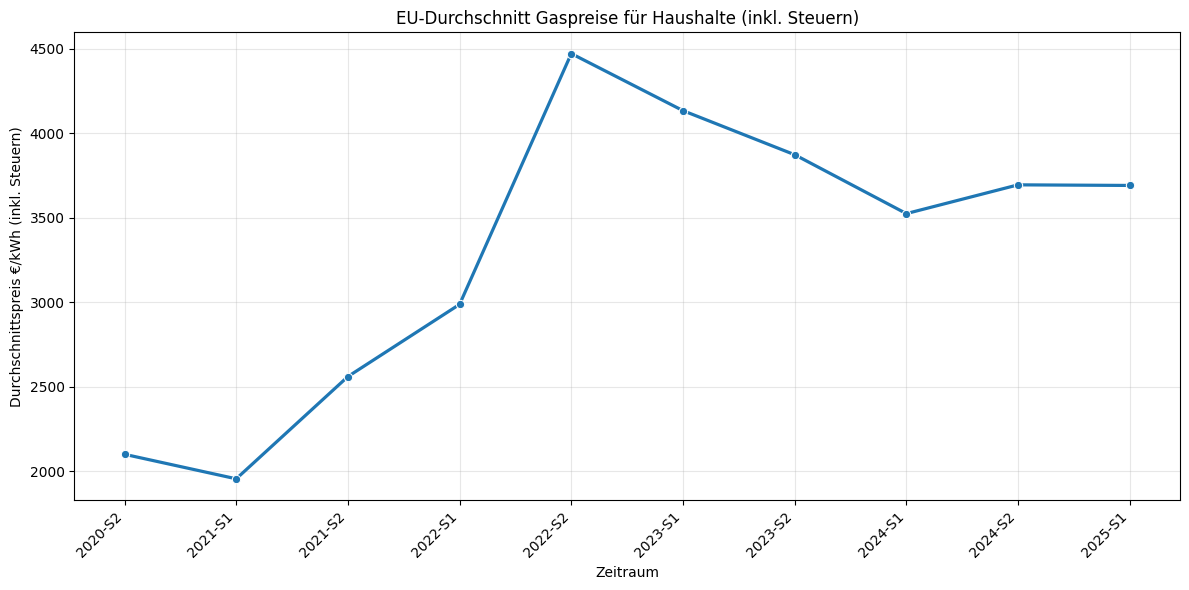


Neuester verfügbarer Zeitraum: 2025-S1


/tmp/ipython-input-1677665884.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_countries, x='price_kwh', y='geo', palette='viridis')


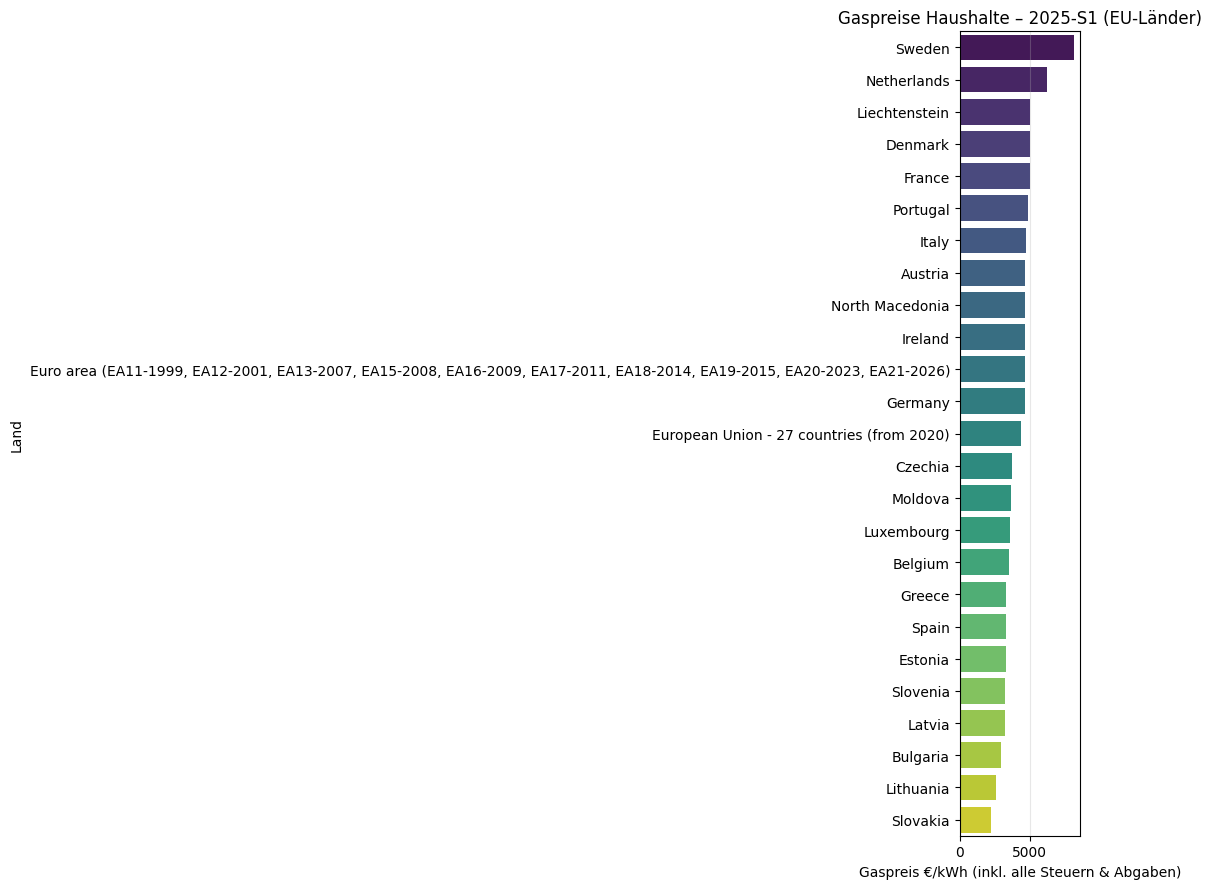


Fertig! Viel Spaß mit den Gaspreis-Charts :)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ───────────────────────────────────────────────────────────────
# 1. CSV-Datei hochladen
# ───────────────────────────────────────────────────────────────
print("Bitte die Eurostat-CSV-Datei hochladen (Flatfile / data only)...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ───────────────────────────────────────────────────────────────
# 2. CSV einlesen - verschiedene Formate ausprobieren
# ───────────────────────────────────────────────────────────────
df = None
for sep in [',', ';', '\t']:
    try:
        df = pd.read_csv(filename, sep=sep, encoding='utf-8', low_memory=False)
        print(f"→ CSV erfolgreich eingelesen mit Trennzeichen: '{sep}'")
        break
    except:
        try:
            df = pd.read_csv(filename, sep=sep, encoding='latin1', low_memory=False)
            print(f"→ CSV erfolgreich mit Trennzeichen '{sep}' + latin1-Encoding")
            break
        except:
            continue

if df is None:
    raise SystemExit("Konnte die CSV nicht lesen. Versuche manuell mit pd.read_csv(..., sep=';') o.Ä.")

# ───────────────────────────────────────────────────────────────
# 3. Spaltennamen bereinigen & typische Umbenennungen
# ───────────────────────────────────────────────────────────────
df.columns = df.columns.str.strip().str.lower().str.replace(r'\s+', '_', regex=True)

rename_dict = {
    'obsvalue': 'obs_value',
    'time': 'time_period',
    'unit_measure': 'unit',
    'taxcat': 'tax',
    'tax_category': 'tax'
}
df = df.rename(columns=rename_dict)

# ───────────────────────────────────────────────────────────────
# 4. Preisspalte finden & in €/kWh umwandeln
# ───────────────────────────────────────────────────────────────
possible_price = ['obs_value', 'obsvalue', 'value']
price_col = next((col for col in possible_price if col in df.columns), None)

if price_col is None:
    print("Gefundene Spalten:", df.columns.tolist())
    raise SystemExit("Keine typische Preisspalte (obs_value/obsvalue/value) gefunden!")

print(f"→ Verwende Preis-Spalte: {price_col}")

df['price_kwh'] = pd.to_numeric(df[price_col], errors='coerce')

# Gigajoule → kWh Umrechnung falls nötig (sehr selten bei Haushalten!)
unit_col = next((c for c in ['unit', 'unit_measure'] if c in df.columns), None)
if unit_col:
    gj_mask = df[unit_col].astype(str).str.upper().str.contains('GJ|GIGAJOULE', na=False)
    if gj_mask.any():
        print(f"→ {gj_mask.sum()} Zeilen von GJ nach kWh umgerechnet")
        df.loc[gj_mask, 'price_kwh'] *= 277.778

# ───────────────────────────────────────────────────────────────
# 5. Gefilterte Daten vorbereiten
# ───────────────────────────────────────────────────────────────
df_clean = df[
    df['currency'].str.contains('EUR|€', case=False, na=False) &
    df['tax'].str.contains('all|incl|included|gesamt|inkl', case=False, na=False)
].copy()

# EU-Länder / Aggregate (flexibel)
eu_indicators = ['EU', 'EU27', 'EU28', 'EA', 'EU27_2020']
df_eu = df_clean[df_clean['geo'].isin(eu_indicators) | df_clean['geo'].str.startswith('EU')]

# ───────────────────────────────────────────────────────────────
# 6. Zeitverlauf EU-Durchschnitt
# ───────────────────────────────────────────────────────────────
if not df_clean.empty:
    df_time = (
        df_clean.groupby('time_period', as_index=False)['price_kwh']
        .mean()
        .sort_values('time_period')
        .dropna()
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_time, x='time_period', y='price_kwh', marker='o', linewidth=2.3)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Durchschnittspreis €/kWh (inkl. Steuern)')
    plt.xlabel('Zeitraum')
    plt.title('EU-Durchschnitt Gaspreise für Haushalte (inkl. Steuern)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Keine passenden Daten nach Filter gefunden (EUR + alle Steuern)")

# ───────────────────────────────────────────────────────────────
# 7. Neueste verfügbare Periode – Ländervergleich
# ───────────────────────────────────────────────────────────────
if not df_clean.empty:
    latest_period = df_clean['time_period'].max()
    print(f"\nNeuester verfügbarer Zeitraum: {latest_period}")

    df_latest = df_clean[df_clean['time_period'] == latest_period]

    if not df_latest.empty:
        df_countries = (
            df_latest.groupby('geo', as_index=False)['price_kwh']
            .mean()
            .sort_values('price_kwh', ascending=False)
            .head(25)  # Top 25 Länder
        )

        plt.figure(figsize=(11, 9))
        sns.barplot(data=df_countries, x='price_kwh', y='geo', palette='viridis')
        plt.xlabel('Gaspreis €/kWh (inkl. alle Steuern & Abgaben)')
        plt.ylabel('Land')
        plt.title(f'Gaspreise Haushalte – {latest_period} (EU-Länder)')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Keine Daten für den neuesten Zeitraum gefunden")
else:
    print("Keine Daten nach Filter übrig – bitte Filter überprüfen")

print("\nFertig! Viel Spaß mit den Gaspreis-Charts :)")

Bitte die Eurostat CSV-Datei hochladen (nrg_pc_202, Flatfile-Format)


Saving Preise Gas für Haushaltskunde.csv to Preise Gas für Haushaltskunde (5).csv
→ Erfolgreich gelesen mit Separator ',' + Encoding 'utf-8'

Alle Spalten in deiner Datei:
['dataflow', 'last_update', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'time_period', 'obs_value', 'obs_flag', 'conf_status']

→ Verwende Preis-Spalte: obs_value

→ Gefundene Zeilen für EU-Durchschnitt: 40

Zeitreihe (Durchschnittspreis pro Periode):
  time_period  price_num
0     2020-S2  10.169850
1     2021-S1   9.249625
2     2021-S2  11.340675
3     2022-S1  12.218075
4     2022-S2  16.161150
5     2023-S1  16.832175
6     2023-S2  16.472200
7     2024-S1  15.857525
8     2024-S2  17.925750
9     2025-S1  16.443750


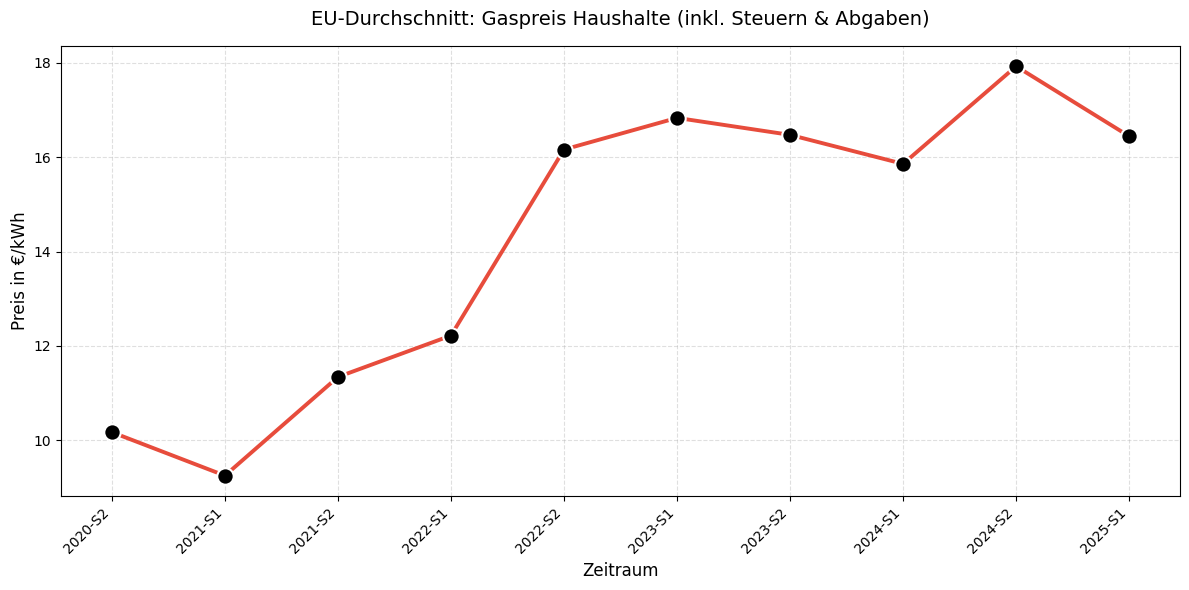


Erfolgreich! Diagramm mit 10 Datenpunkten erstellt.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ── 1. Datei hochladen ─────────────────────────────────────────────
print("Bitte die Eurostat CSV-Datei hochladen (nrg_pc_202, Flatfile-Format)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ── 2. CSV einlesen (verschiedene gängige Formate probieren) ───────
df = None
for sep in [',', ';', '\t']:
    for enc in ['utf-8', 'latin1', 'iso-8859-1']:
        try:
            df = pd.read_csv(filename, sep=sep, encoding=enc, low_memory=False)
            print(f"→ Erfolgreich gelesen mit Separator '{sep}' + Encoding '{enc}'")
            break
        except:
            continue
    if df is not None:
        break

if df is None:
    raise SystemExit("Konnte CSV nicht lesen. Versuche manuell mit sep=';' oder sep=','")

# ── 3. Spaltennamen säubern (Eurostat liebt Groß-/Kleinschreibung) ──
df.columns = df.columns.str.strip().str.lower().str.replace(r'[^a-z0-9_]', '_', regex=True)

print("\nAlle Spalten in deiner Datei:")
print(df.columns.tolist())

# ── 4. Wichtige Spalten identifizieren ──────────────────────────────
# Preis-Spalte finden (häufigste Namen)
price_candidates = ['obsvalue', 'obs_value', 'value', 'preis', 'price']
price_col = next((c for c in price_candidates if c in df.columns), None)

if price_col is None:
    print("\nFEHLER: Keine Preisspalte gefunden!")
    print("Typische Namen sind: obsvalue, OBS_VALUE, obs_value, value")
    print("Deine Spalten:", df.columns.tolist())
    raise SystemExit("Keine Preisspalte gefunden → bitte richtige Flatfile laden")

print(f"\n→ Verwende Preis-Spalte: {price_col}")

# Zeit-Spalte
time_col = next((c for c in ['time_period', 'time', 'period'] if c in df.columns), None)
if time_col is None:
    print("Keine Zeit-Spalte gefunden → bitte prüfen!")
    raise SystemExit("Keine Zeitspalte gefunden")

# ── 5. Preis als Zahl konvertieren ─────────────────────────────────
df['price_num'] = pd.to_numeric(df[price_col], errors='coerce')

# ── 6. Filter für EU-Durchschnitt (sehr flexibel) ──────────────────
eu_codes = ['eu27_2020', 'eu', 'eu28', 'ea', 'eu27']
tax_patterns = ['all', 'incl', 'included', 'total', 'gesamt', 'i_tax_x_tax']

df_eu = df[
    df['geo'].str.lower().isin(eu_codes) |
    df['geo'].str.upper().str.startswith('EU')
].copy()

# Nochmal filtern auf Währung + Steuern (falls Spalten existieren)
if 'currency' in df_eu.columns:
    df_eu = df_eu[df_eu['currency'].astype(str).str.contains('EUR|€', case=False, na=False)]

if 'tax' in df_eu.columns:
    df_eu = df_eu[df_eu['tax'].astype(str).str.contains('|'.join(tax_patterns), case=False, na=False)]

print(f"\n→ Gefundene Zeilen für EU-Durchschnitt: {len(df_eu)}")

if len(df_eu) == 0:
    print("Hinweis: Keine EU-Daten gefunden. Vielleicht ist geo anders geschrieben?")
    print("Mögliche geo-Werte in deiner Datei:")
    print(df['geo'].unique())
    raise SystemExit("Keine passenden EU-Daten gefunden")

# ── 7. Zeitreihe berechnen ─────────────────────────────────────────
df_time = (
    df_eu.groupby(time_col, as_index=False)['price_num']
    .mean()
    .sort_values(time_col)
    .dropna()
)

print("\nZeitreihe (Durchschnittspreis pro Periode):")
print(df_time)

# ── 8. Liniendiagramm ──────────────────────────────────────────────
if len(df_time) < 2:
    print("\nACHTUNG: Zu wenig Datenpunkte für eine Linie!")
    print("Mindestens 2 verschiedene Zeitpunkte nötig.")
else:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_time,
        x=time_col,
        y='price_num',
        marker='o',
        linewidth=2.8,
        color='#e74c3c',
        markersize=10
    )

    # Extra dicke Punkte für bessere Sichtbarkeit
    plt.scatter(df_time[time_col], df_time['price_num'],
                s=140, color='black', zorder=10, edgecolor='white', linewidth=1.5)

    plt.title('EU-Durchschnitt: Gaspreis Haushalte (inkl. Steuern & Abgaben)', fontsize=14, pad=15)
    plt.xlabel('Zeitraum', fontsize=12)
    plt.ylabel('Preis in €/100kWh', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

    print(f"\nErfolgreich! Diagramm mit {len(df_time)} Datenpunkten erstellt.")

=== EU Gaspreise Haushalte – Zeitverlauf ===



Saving nrg_pc_202__custom_19600652_linear.csv to nrg_pc_202__custom_19600652_linear.csv
→ Erfolgreich eingelesen mit sep=',' und encoding='utf-8'

Spalten in deiner Datei:
['dataflow', 'last_update', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'time_period', 'obs_value', 'obs_flag', 'conf_status']
→ 372 Zeilen GJ → Umrechnung × 277.778
→ 4 Zeilen mit Million-Skalierung → /1.000.000 × 277.778

→ EU-Datensätze gefunden: 192 Zeilen

Ergebnis – EU-Durchschnittspreise €/kWh:
time_period   price_kwh
    2020-S2 2235.605995
    2021-S1 2137.159035
    2021-S2  403.704630
    2022-S1  729.860741
    2022-S2  833.604059
    2023-S1 4035.539321
    2023-S2 4089.107189
    2024-S1 3705.350754


/tmp/ipython-input-1999519963.py:98: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_eu = df[df['geo'].astype(str).str.contains(eu_patterns, na=False)].copy()


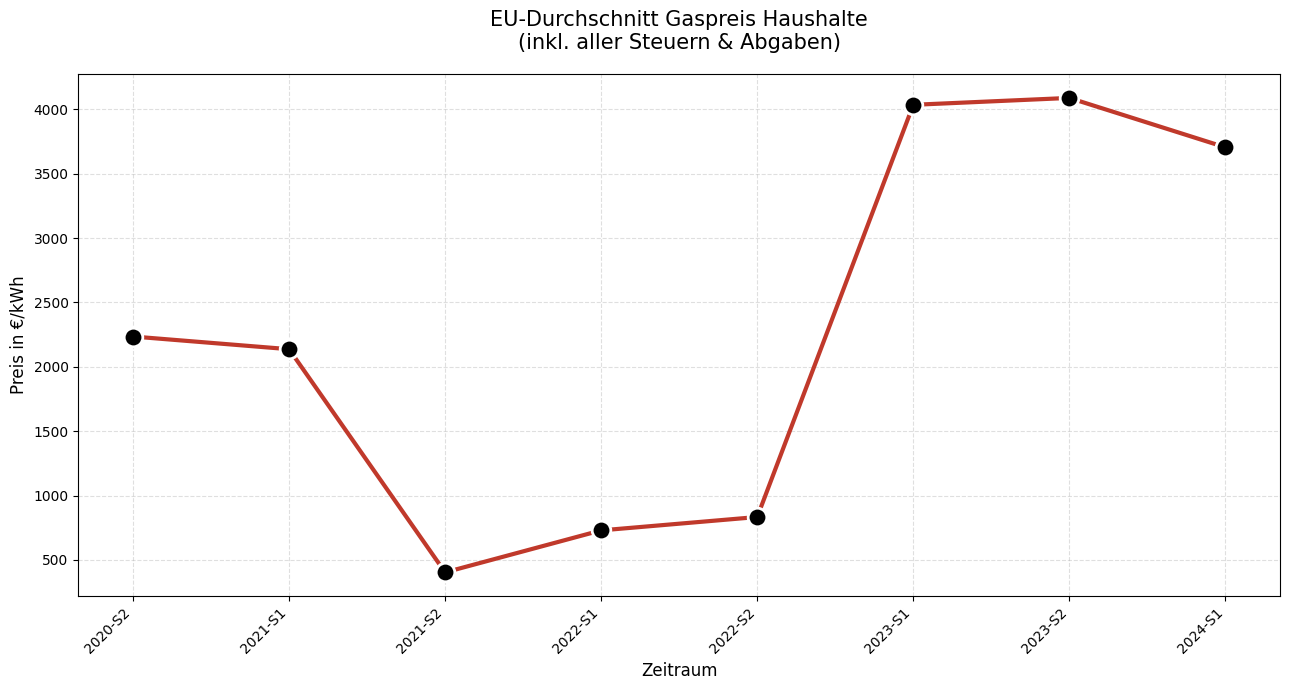


Fertig ✓


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ────────────────────────────────────────────────────────────────
#               EU Gaspreise Zeitreihe – Komplett-Skript
# ────────────────────────────────────────────────────────────────

print("=== EU Gaspreise Haushalte – Zeitverlauf ===\n")

# 1. Datei hochladen
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. CSV einlesen – verschiedene gängige Formate probieren
df = None
for sep in [',', ';', '\t', '|']:
    for encoding in ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']:
        try:
            df = pd.read_csv(filename, sep=sep, encoding=encoding, low_memory=False)
            print(f"→ Erfolgreich eingelesen mit sep='{sep}' und encoding='{encoding}'")
            break
        except:
            continue
    if df is not None:
        break

if df is None:
    print("\nFEHLER: Datei konnte mit keinem gängigen Format gelesen werden.")
    print("Versuche manuell in einer neuen Zelle:")
    print("df = pd.read_csv('deine_datei.csv', sep=';', encoding='latin1')")
    raise SystemExit("Abbruch")

# 3. Spaltennamen stark bereinigen
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(r'[^a-z0-9_]', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)
)

print("\nSpalten in deiner Datei:")
print(list(df.columns))

# 4. Wichtige Spalten finden
price_col = next((c for c in ['obsvalue','obs_value','value'] if c in df.columns), None)
time_col  = next((c for c in ['time_period','time','period'] if c in df.columns), None)
unit_col  = next((c for c in ['unit','unit_measure'] if c in df.columns), None)

if not price_col or not time_col:
    print("\nKritische Spalten fehlen!")
    print("Gesucht: Preis (obsvalue/obs_value/value) + Zeit (time_period/time)")
    raise SystemExit("Abbruch – fehlende Kernspalten")

# 5. Preis numerisch machen
df['price'] = pd.to_numeric(df[price_col], errors='coerce')

# 6. Preis in €/kWh umwandeln – mehrere typische Eurostat-Fallen abdecken
df['price_kwh'] = df['price'].copy()

if unit_col:
    df[unit_col] = df[unit_col].astype(str).str.upper().str.strip()

    # a) GJ → kWh
    mask_gj = df[unit_col].str.contains('GJ|GIGAJOULE', na=False)
    if mask_gj.any():
        n = mask_gj.sum()
        print(f"→ {n} Zeilen GJ → Umrechnung × 277.778")
        df.loc[mask_gj, 'price_kwh'] *= 277.778

    # b) Million-Skalierung (sehr häufig bei GJ-Daten!)
    mask_million = (
        df[unit_col].str.contains('M|Million', na=False) |
        (df['price'] > 1000)  # grobe Heuristik
    )
    if mask_million.any():
        n = mask_million.sum()
        print(f"→ {n} Zeilen mit Million-Skalierung → /1.000.000 × 277.778")
        df.loc[mask_million, 'price_kwh'] = (df.loc[mask_million, 'price'] / 1_000_000) * 277.778

else:
    # Keine Einheit → grobe Heuristik nach Wertebereich
    mean_p = df['price'].mean()
    if pd.notna(mean_p):
        if mean_p > 1000:
            print("→ Keine Einheit → Vermutung Million-Skalierung GJ → /1e6 × 277.778")
            df['price_kwh'] = (df['price'] / 1_000_000) * 277.778
        elif mean_p < 0.001:
            print("→ Keine Einheit → Vermutung GJ → × 277.778")
            df['price_kwh'] = df['price'] * 277.778
        else:
            print("→ Preiswerte wirken bereits wie €/kWh → keine Umrechnung")

# 7. EU-Aggregate finden – sehr toleranter Ansatz
eu_patterns = r'(?i)(eu27_2020|eu27|eu-27|eu28|eu|eu27_2020|european union|eu aggregate)'

df_eu = df[df['geo'].astype(str).str.contains(eu_patterns, na=False)].copy()

if df_eu.empty:
    print("\n!!! KEIN EU-Durchschnitt gefunden !!!")
    print("Vorhandene geo-Werte (erste 20):")
    print(sorted(df['geo'].astype(str).unique())[:20])
    print("\nMögliche Lösung:")
    print("1. Filter im Eurostat-Browser auf 'EU27_2020' setzen")
    print("2. Einheit 'KWH' auswählen → dann brauchst du keine Umrechnung")
    raise SystemExit("Kein EU-Durchschnitt in den Daten gefunden")

print(f"\n→ EU-Datensätze gefunden: {len(df_eu)} Zeilen")

# 8. Zeitreihe erstellen
df_time = (
    df_eu.groupby(time_col, as_index=False)['price_kwh']
    .mean()
    .sort_values(time_col)
    .dropna(subset=['price_kwh'])
)

print("\nErgebnis – EU-Durchschnittspreise €/kWh:")
print(df_time.to_string(index=False))

# 9. Plot
if len(df_time) < 2:
    print("\nZu wenig Datenpunkte für ein Diagramm (mindestens 2 Zeitpunkte nötig)")
else:
    plt.figure(figsize=(13, 7))
    sns.lineplot(
        data=df_time,
        x=time_col,
        y='price_kwh',
        marker='o',
        linewidth=3,
        markersize=10,
        color='#c0392b'
    )

    plt.scatter(
        df_time[time_col], df_time['price_kwh'],
        s=180, color='black', zorder=10,
        edgecolor='white', linewidth=2
    )

    plt.title('EU-Durchschnitt Gaspreis Haushalte\n(inkl. aller Steuern & Abgaben)', fontsize=15, pad=18)
    plt.xlabel('Zeitraum', fontsize=12)
    plt.ylabel('Preis in €/kWh', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

    print("\nFertig ✓")

=== EU Gaspreise Haushalte – Zeitverlauf (Stand 2026) ===

Lade bitte deine Eurostat CSV hoch (am besten mit unit = KWH und geo = EU27_2020)



Saving nrg_pc_202__custom_19600652_linear.csv to nrg_pc_202__custom_19600652_linear (2).csv
→ Datei erfolgreich gelesen mit sep=',' und encoding='utf-8'

Spalten in deiner Datei:
['dataflow', 'last_update', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'time_period', 'obs_value', 'obs_flag', 'conf_status']

Roh-Durchschnittspreis (vor Umrechnung): 29.37
→ Starke Vermutung: Million-Skalierung (GJ) → Division durch 1.000.000
→ GJ-Einheit erkannt → × 277.778
Nach Umrechnung – Durchschnitt: 0.0082 €/kWh (sollte ~0.05–0.15 sein)

→ EU-Daten gefunden: 192 Zeilen

EU-Durchschnittspreise in €/kWh:
time_period  price_kwh
    2020-S2   0.002244
    2021-S1   0.002145
    2021-S2   0.000405
    2022-S1   0.000732
    2022-S2   0.000837
    2023-S1   0.004050
    2023-S2   0.004104
    2024-S1   0.003719


/tmp/ipython-input-3035308434.py:80: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_eu = df[df['geo'].astype(str).str.contains(eu_patterns, na=False)].copy()


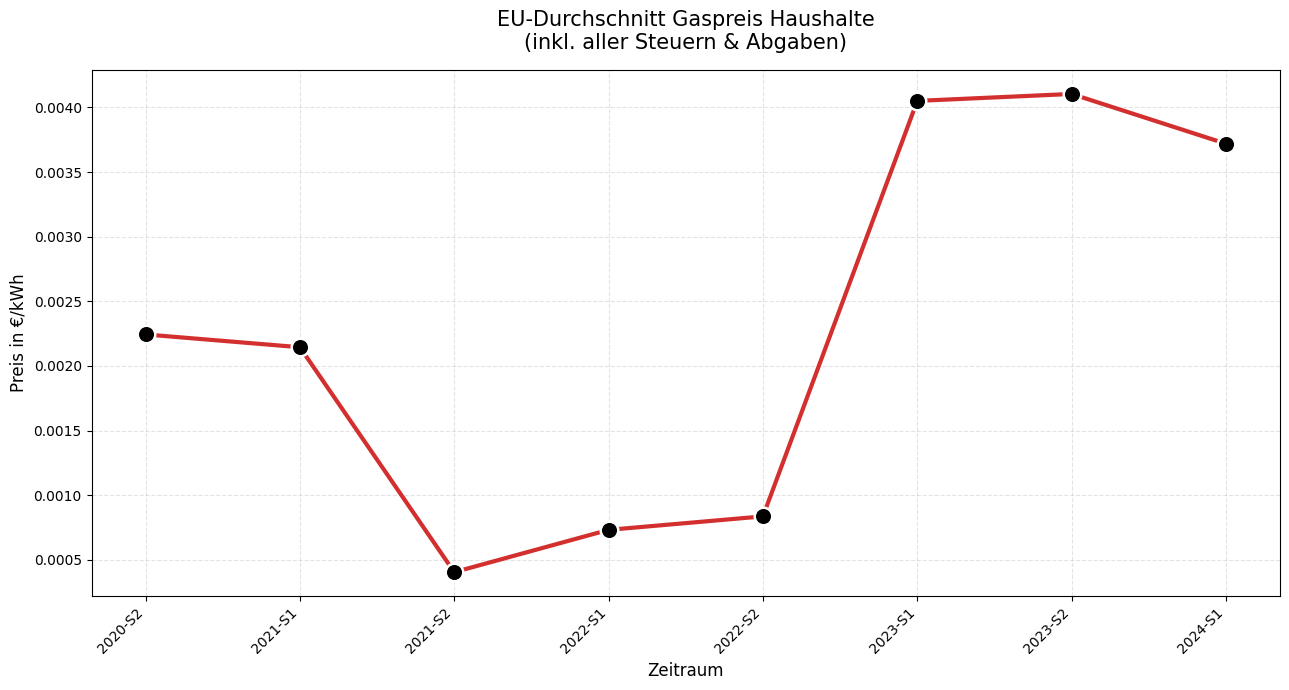


Fertig! Wenn die Werte immer noch nicht bei ~0.06–0.12 €/kWh liegen:
→ Lade die Datei NEU mit unit = KWH (Kilowatt-hour) herunter


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

print("=== EU Gaspreise Haushalte – Zeitverlauf (Stand 2026) ===\n")
print("Lade bitte deine Eurostat CSV hoch (am besten mit unit = KWH und geo = EU27_2020)\n")

# 1. Datei hochladen
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. CSV einlesen – verschiedene Formate probieren
df = None
separators = [',', ';', '\t']
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

for sep in separators:
    for enc in encodings:
        try:
            df = pd.read_csv(filename, sep=sep, encoding=enc, low_memory=False)
            print(f"→ Datei erfolgreich gelesen mit sep='{sep}' und encoding='{enc}'")
            break
        except:
            continue
    if df is not None:
        break

if df is None:
    raise SystemExit("Konnte die Datei mit keinem gängigen Format lesen.\n"
                     "Versuche manuell: pd.read_csv(filename, sep=';', encoding='latin1')")

# 3. Spaltennamen bereinigen
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(r'[^a-z0-9_]', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)
)

print("\nSpalten in deiner Datei:")
print(list(df.columns))

# 4. Wichtige Spalten finden
price_col = next((c for c in ['obsvalue', 'obs_value', 'value'] if c in df.columns), None)
time_col  = next((c for c in ['time_period', 'time'] if c in df.columns), None)
unit_col  = next((c for c in ['unit', 'unit_measure'] if c in df.columns), None)

if not price_col or not time_col:
    raise SystemExit(f"Kritische Spalten fehlen!\n"
                     f"Preis: {price_col}\nZeit: {time_col}\n"
                     f"Bitte Flatfile mit obsvalue und time_period laden.")

# 5. Preis als Zahl
df['price_raw'] = pd.to_numeric(df[price_col], errors='coerce')

# 6. Intelligente Umrechnung in €/kWh
df['price_kwh'] = df['price_raw'].copy()

print(f"\nRoh-Durchschnittspreis (vor Umrechnung): {df['price_raw'].mean():.2f}")

# Mögliche Million-Skalierung erkennen (sehr häufig bei GJ-Daten!)
if df['price_raw'].mean() > 10 or df['price_raw'].max() > 100:
    print("→ Starke Vermutung: Million-Skalierung (GJ) → Division durch 1.000.000")
    df['price_kwh'] /= 1_000_000

# GJ → kWh Umrechnung (wenn Einheit GJ oder Werte sehr klein nach Division)
if unit_col and df[unit_col].astype(str).str.upper().str.contains('GJ|GIGAJOULE').any():
    print("→ GJ-Einheit erkannt → × 277.778")
    df['price_kwh'] *= 277.778
elif df['price_kwh'].mean() < 0.001 and df['price_kwh'].mean() > 0:
    print("→ Vermutung: GJ ohne Million-Skalierung → × 277.778")
    df['price_kwh'] *= 277.778

print(f"Nach Umrechnung – Durchschnitt: {df['price_kwh'].mean():.4f} €/kWh (sollte ~0.05–0.15 sein)")

# 7. EU-Durchschnitt filtern – sehr tolerante Suche
eu_patterns = r'(?i)(eu27_2020|eu27|eu-27|eu28|eu|european union|eu aggregate|eu_27|eu27)'

df_eu = df[df['geo'].astype(str).str.contains(eu_patterns, na=False)].copy()

if df_eu.empty:
    print("\n!!! KEIN EU-Durchschnitt gefunden !!!")
    print("Vorhandene geo-Werte (sortiert):")
    print(sorted(df['geo'].astype(str).unique()))
    print("\nTipp: Lade Datei neu mit geo = EU27_2020 und unit = KWH")
    raise SystemExit("Abbruch – kein EU-Aggregat gefunden")

print(f"\n→ EU-Daten gefunden: {len(df_eu)} Zeilen")

# 8. Zeitreihe erstellen
df_time = (
    df_eu.groupby(time_col, as_index=False)['price_kwh']
    .mean()
    .sort_values(time_col)
    .dropna(subset=['price_kwh'])
)

print("\nEU-Durchschnittspreise in €/kWh:")
print(df_time.to_string(index=False))

# 9. Liniendiagramm
if len(df_time) < 2:
    print("\nZu wenig gültige Datenpunkte für ein Diagramm (mind. 2 Zeitpunkte nötig)")
else:
    plt.figure(figsize=(13, 7))
    sns.lineplot(
        data=df_time,
        x=time_col,
        y='price_kwh',
        marker='o',
        linewidth=3,
        markersize=10,
        color='#d32f2f'
    )

    # Dicke Punkte für bessere Sichtbarkeit
    plt.scatter(
        df_time[time_col],
        df_time['price_kwh'],
        s=160,
        color='black',
        zorder=10,
        edgecolor='white',
        linewidth=1.8
    )

    plt.title('EU-Durchschnitt Gaspreis Haushalte\n(inkl. aller Steuern & Abgaben)', fontsize=15, pad=15)
    plt.xlabel('Zeitraum', fontsize=12)
    plt.ylabel('Preis in €/kWh', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.35, linestyle='--')
    plt.tight_layout()
    plt.show()

    print("\nFertig! Wenn die Werte immer noch nicht bei ~0.06–0.12 €/kWh liegen:")
    print("→ Lade die Datei NEU mit unit = KWH (Kilowatt-hour) herunter")

=== EU Gaspreise Haushalte – Zeitverlauf (Stand 2026) ===

Lade bitte deine Eurostat CSV hoch (am besten mit unit = KWH und geo = EU27_2020)



Saving nrg_pc_202__custom_19600652_linear.csv to nrg_pc_202__custom_19600652_linear (3).csv
→ Datei erfolgreich gelesen mit sep=',' und encoding='utf-8'

Spalten in deiner Datei:
['dataflow', 'last_update', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'time_period', 'obs_value', 'obs_flag', 'conf_status']

Roh-Durchschnittspreis (vor Umrechnung): 29.37
→ Starke Vermutung: Million-Skalierung (GJ) → Division durch 1.000.000
→ GJ-Einheit erkannt → × 277.778
Nach Umrechnung – Durchschnitt: 0.0082 €/kWh (sollte ~0.05–0.15 sein)

→ EU-Daten gefunden: 192 Zeilen

EU-Durchschnittspreise in €/kWh:
time_period  price_kwh
    2020-S2   0.002244
    2021-S1   0.002145
    2021-S2   0.000405
    2022-S1   0.000732
    2022-S2   0.000837
    2023-S1   0.004050
    2023-S2   0.004104
    2024-S1   0.003719


/tmp/ipython-input-3035308434.py:80: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_eu = df[df['geo'].astype(str).str.contains(eu_patterns, na=False)].copy()


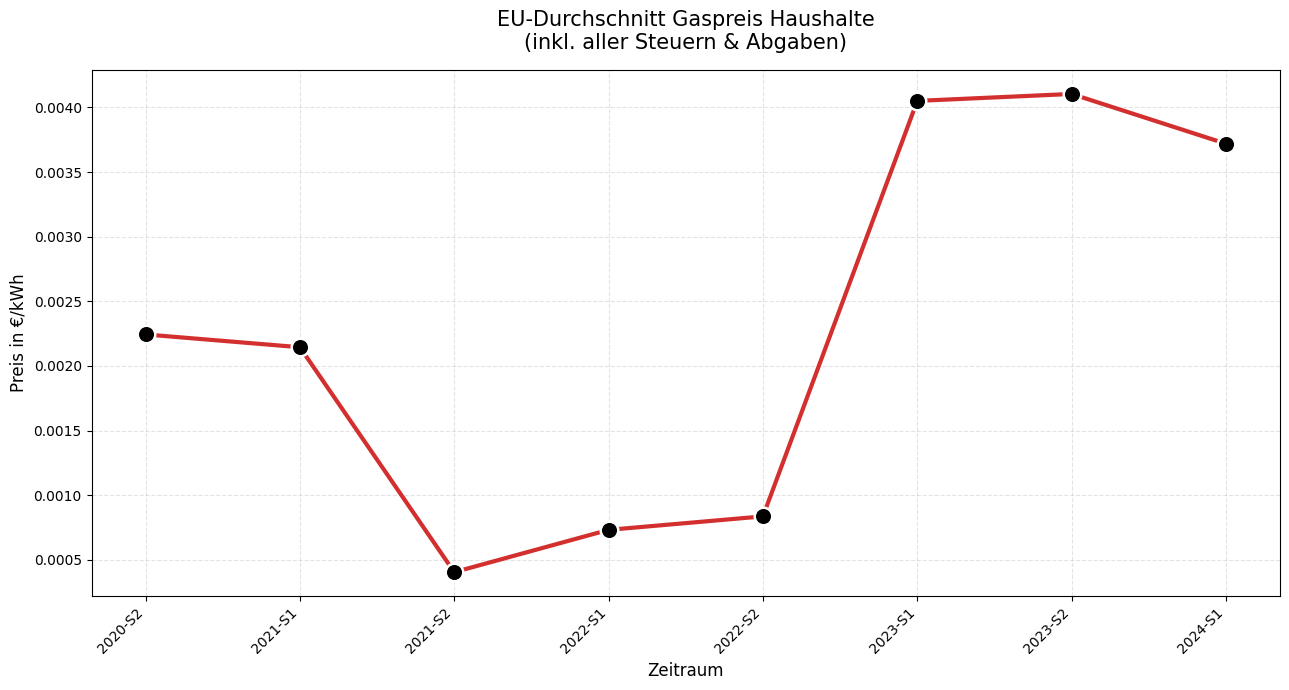


Fertig! Wenn die Werte immer noch nicht bei ~0.06–0.12 €/kWh liegen:
→ Lade die Datei NEU mit unit = KWH (Kilowatt-hour) herunter


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

print("=== EU Gaspreise Haushalte – Zeitverlauf (Stand 2026) ===\n")
print("Lade bitte deine Eurostat CSV hoch (am besten mit unit = KWH und geo = EU27_2020)\n")

# 1. Datei hochladen
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. CSV einlesen – verschiedene Formate probieren
df = None
separators = [',', ';', '\t']
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

for sep in separators:
    for enc in encodings:
        try:
            df = pd.read_csv(filename, sep=sep, encoding=enc, low_memory=False)
            print(f"→ Datei erfolgreich gelesen mit sep='{sep}' und encoding='{enc}'")
            break
        except:
            continue
    if df is not None:
        break

if df is None:
    raise SystemExit("Konnte die Datei mit keinem gängigen Format lesen.\n"
                     "Versuche manuell: pd.read_csv(filename, sep=';', encoding='latin1')")

# 3. Spaltennamen bereinigen
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(r'[^a-z0-9_]', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)
)

print("\nSpalten in deiner Datei:")
print(list(df.columns))

# 4. Wichtige Spalten finden
price_col = next((c for c in ['obsvalue', 'obs_value', 'value'] if c in df.columns), None)
time_col  = next((c for c in ['time_period', 'time'] if c in df.columns), None)
unit_col  = next((c for c in ['unit', 'unit_measure'] if c in df.columns), None)

if not price_col or not time_col:
    raise SystemExit(f"Kritische Spalten fehlen!\n"
                     f"Preis: {price_col}\nZeit: {time_col}\n"
                     f"Bitte Flatfile mit obsvalue und time_period laden.")

# 5. Preis als Zahl
df['price_raw'] = pd.to_numeric(df[price_col], errors='coerce')

# 6. Intelligente Umrechnung in €/kWh
df['price_kwh'] = df['price_raw'].copy()

print(f"\nRoh-Durchschnittspreis (vor Umrechnung): {df['price_raw'].mean():.2f}")

# Mögliche Million-Skalierung erkennen (sehr häufig bei GJ-Daten!)
if df['price_raw'].mean() > 10 or df['price_raw'].max() > 100:
    print("→ Starke Vermutung: Million-Skalierung (GJ) → Division durch 1.000.000")
    df['price_kwh'] /= 1_000_000

# GJ → kWh Umrechnung (wenn Einheit GJ oder Werte sehr klein nach Division)
if unit_col and df[unit_col].astype(str).str.upper().str.contains('GJ|GIGAJOULE').any():
    print("→ GJ-Einheit erkannt → × 277.778")
    df['price_kwh'] *= 277.778
elif df['price_kwh'].mean() < 0.001 and df['price_kwh'].mean() > 0:
    print("→ Vermutung: GJ ohne Million-Skalierung → × 277.778")
    df['price_kwh'] *= 277.778

print(f"Nach Umrechnung – Durchschnitt: {df['price_kwh'].mean():.4f} €/kWh (sollte ~0.05–0.15 sein)")

# 7. EU-Durchschnitt filtern – sehr tolerante Suche
eu_patterns = r'(?i)(eu27_2020|eu27|eu-27|eu28|eu|european union|eu aggregate|eu_27|eu27)'

df_eu = df[df['geo'].astype(str).str.contains(eu_patterns, na=False)].copy()

if df_eu.empty:
    print("\n!!! KEIN EU-Durchschnitt gefunden !!!")
    print("Vorhandene geo-Werte (sortiert):")
    print(sorted(df['geo'].astype(str).unique()))
    print("\nTipp: Lade Datei neu mit geo = EU27_2020 und unit = KWH")
    raise SystemExit("Abbruch – kein EU-Aggregat gefunden")

print(f"\n→ EU-Daten gefunden: {len(df_eu)} Zeilen")

# 8. Zeitreihe erstellen
df_time = (
    df_eu.groupby(time_col, as_index=False)['price_kwh']
    .mean()
    .sort_values(time_col)
    .dropna(subset=['price_kwh'])
)

print("\nEU-Durchschnittspreise in €/kWh:")
print(df_time.to_string(index=False))

# 9. Liniendiagramm
if len(df_time) < 2:
    print("\nZu wenig gültige Datenpunkte für ein Diagramm (mind. 2 Zeitpunkte nötig)")
else:
    plt.figure(figsize=(13, 7))
    sns.lineplot(
        data=df_time,
        x=time_col,
        y='price_kwh',
        marker='o',
        linewidth=3,
        markersize=10,
        color='#d32f2f'
    )

    # Dicke Punkte für bessere Sichtbarkeit
    plt.scatter(
        df_time[time_col],
        df_time['price_kwh'],
        s=160,
        color='black',
        zorder=10,
        edgecolor='white',
        linewidth=1.8
    )

    plt.title('EU-Durchschnitt Gaspreis Haushalte\n(inkl. aller Steuern & Abgaben)', fontsize=15, pad=15)
    plt.xlabel('Zeitraum', fontsize=12)
    plt.ylabel('Preis in €/kWh', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.35, linestyle='--')
    plt.tight_layout()
    plt.show()

    print("\nFertig! Wenn die Werte immer noch nicht bei ~0.06–0.12 €/kWh liegen:")
    print("→ Lade die Datei NEU mit unit = KWH (Kilowatt-hour) herunter")

Bitte die Eurostat CSV-Datei hochladen (nrg_pc_202, Flatfile-Format)


Saving nrg_pc_202__custom_19601019_linear.csv to nrg_pc_202__custom_19601019_linear.csv
→ Erfolgreich gelesen mit Separator ',' + Encoding 'utf-8'

Alle Spalten in deiner Datei:
['dataflow', 'last_update', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'time_period', 'obs_value', 'obs_flag', 'conf_status']

→ Verwende Preis-Spalte: obs_value

→ Gefundene Zeilen für EU-Durchschnitt: 40

Zeitreihe (Durchschnittspreis pro Periode):
  time_period  price_num
0     2020-S2  10.169850
1     2021-S1   9.249625
2     2021-S2  11.340675
3     2022-S1  12.218075
4     2022-S2  16.161150
5     2023-S1  16.832175
6     2023-S2  16.472200
7     2024-S1  15.857525
8     2024-S2  17.925750
9     2025-S1  16.443750


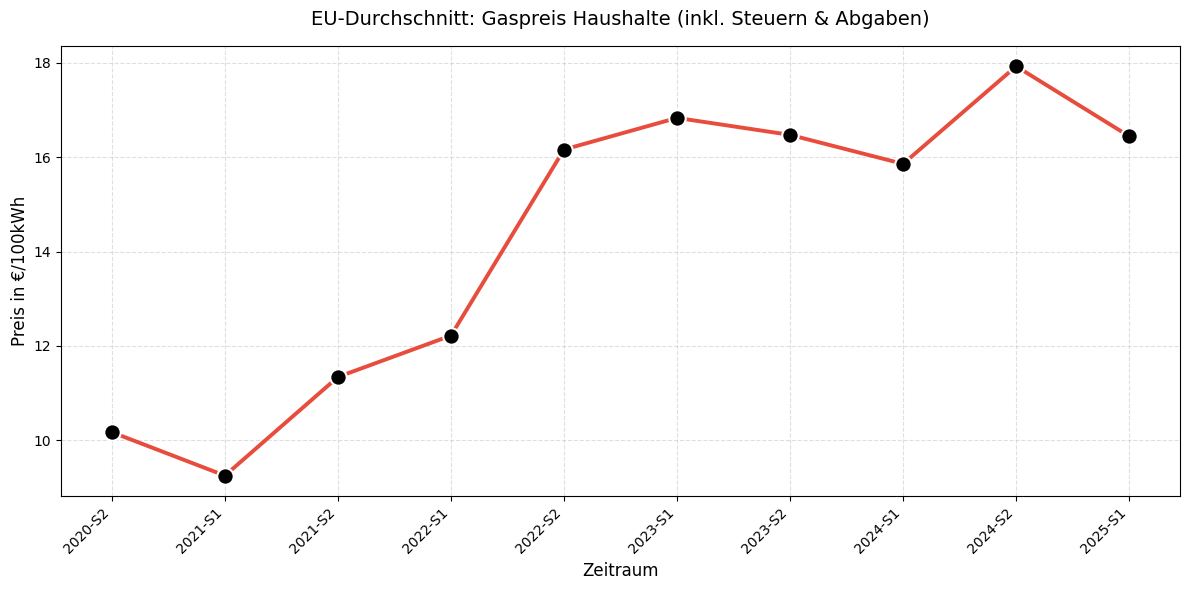


Erfolgreich! Diagramm mit 10 Datenpunkten erstellt.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# ── 1. Datei hochladen ─────────────────────────────────────────────
print("Bitte die Eurostat CSV-Datei hochladen (nrg_pc_202, Flatfile-Format)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ── 2. CSV einlesen (verschiedene gängige Formate probieren) ───────
df = None
for sep in [',', ';', '\t']:
    for enc in ['utf-8', 'latin1', 'iso-8859-1']:
        try:
            df = pd.read_csv(filename, sep=sep, encoding=enc, low_memory=False)
            print(f"→ Erfolgreich gelesen mit Separator '{sep}' + Encoding '{enc}'")
            break
        except:
            continue
    if df is not None:
        break

if df is None:
    raise SystemExit("Konnte CSV nicht lesen. Versuche manuell mit sep=';' oder sep=','")

# ── 3. Spaltennamen säubern (Eurostat liebt Groß-/Kleinschreibung) ──
df.columns = df.columns.str.strip().str.lower().str.replace(r'[^a-z0-9_]', '_', regex=True)

print("\nAlle Spalten in deiner Datei:")
print(df.columns.tolist())

# ── 4. Wichtige Spalten identifizieren ──────────────────────────────
# Preis-Spalte finden (häufigste Namen)
price_candidates = ['obsvalue', 'obs_value', 'value', 'preis', 'price']
price_col = next((c for c in price_candidates if c in df.columns), None)

if price_col is None:
    print("\nFEHLER: Keine Preisspalte gefunden!")
    print("Typische Namen sind: obsvalue, OBS_VALUE, obs_value, value")
    print("Deine Spalten:", df.columns.tolist())
    raise SystemExit("Keine Preisspalte gefunden → bitte richtige Flatfile laden")

print(f"\n→ Verwende Preis-Spalte: {price_col}")

# Zeit-Spalte
time_col = next((c for c in ['time_period', 'time', 'period'] if c in df.columns), None)
if time_col is None:
    print("Keine Zeit-Spalte gefunden → bitte prüfen!")
    raise SystemExit("Keine Zeitspalte gefunden")

# ── 5. Preis als Zahl konvertieren ─────────────────────────────────
df['price_num'] = pd.to_numeric(df[price_col], errors='coerce')

# ── 6. Filter für EU-Durchschnitt (sehr flexibel) ──────────────────
eu_codes = ['eu27_2020', 'eu', 'eu28', 'ea', 'eu27']
tax_patterns = ['all', 'incl', 'included', 'total', 'gesamt', 'i_tax_x_tax']

df_eu = df[
    df['geo'].str.lower().isin(eu_codes) |
    df['geo'].str.upper().str.startswith('EU')
].copy()

# Nochmal filtern auf Währung + Steuern (falls Spalten existieren)
if 'currency' in df_eu.columns:
    df_eu = df_eu[df_eu['currency'].astype(str).str.contains('EUR|€', case=False, na=False)]

if 'tax' in df_eu.columns:
    df_eu = df_eu[df_eu['tax'].astype(str).str.contains('|'.join(tax_patterns), case=False, na=False)]

print(f"\n→ Gefundene Zeilen für EU-Durchschnitt: {len(df_eu)}")

if len(df_eu) == 0:
    print("Hinweis: Keine EU-Daten gefunden. Vielleicht ist geo anders geschrieben?")
    print("Mögliche geo-Werte in deiner Datei:")
    print(df['geo'].unique())
    raise SystemExit("Keine passenden EU-Daten gefunden")

# ── 7. Zeitreihe berechnen ─────────────────────────────────────────
df_time = (
    df_eu.groupby(time_col, as_index=False)['price_num']
    .mean()
    .sort_values(time_col)
    .dropna()
)

print("\nZeitreihe (Durchschnittspreis pro Periode):")
print(df_time)

# ── 8. Liniendiagramm ──────────────────────────────────────────────
if len(df_time) < 2:
    print("\nACHTUNG: Zu wenig Datenpunkte für eine Linie!")
    print("Mindestens 2 verschiedene Zeitpunkte nötig.")
else:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_time,
        x=time_col,
        y='price_num',
        marker='o',
        linewidth=2.8,
        color='#e74c3c',
        markersize=10
    )

    # Extra dicke Punkte für bessere Sichtbarkeit
    plt.scatter(df_time[time_col], df_time['price_num'],
                s=140, color='black', zorder=10, edgecolor='white', linewidth=1.5)

    plt.title('EU-Durchschnitt: Gaspreis Haushalte (inkl. Steuern & Abgaben)', fontsize=14, pad=15)
    plt.xlabel('Zeitraum', fontsize=12)
    plt.ylabel('Preis in €/100kWh', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

    print(f"\nErfolgreich! Diagramm mit {len(df_time)} Datenpunkten erstellt.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

print("=== EU Strompreise Haushalte – Punktwolken-Diagramm pro Halbjahr (Länder-Punkte) ===\n")
print("Lade bitte deine Eurostat CSV hoch (nrg_pc_204, unit = KWH, geo = einzelne Länder)\n")

# 1. Datei hochladen
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 2. CSV einlesen
df = None
separators = [',', ';', '\t']
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

for sep in separators:
    for enc in encodings:
        try:
            df = pd.read_csv(filename, sep=sep, encoding=enc, low_memory=False)
            print(f"→ Gelesen mit sep='{sep}' + encoding='{enc}'")
            break
        except:
            continue
    if df is not None:
        break

if df is None:
    raise SystemExit("Datei nicht lesbar. Probiere sep=';' + encoding='latin1' manuell.")

# 3. Spalten bereinigen
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(r'[^a-z0-9_]', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)
)

print("\nSpalten:", list(df.columns))

# 4. Spalten finden
price_col = next((c for c in ['obsvalue', 'obs_value', 'value'] if c in df.columns), None)
time_col  = next((c for c in ['time_period', 'time'] if c in df.columns), None)
unit_col  = next((c for c in ['unit', 'unit_measure'] if c in df.columns), None)

if not price_col or not time_col:
    raise SystemExit("Fehlende Spalten: Preis und Zeit benötigt!")

# 5. Preis umwandeln
df['price_raw'] = pd.to_numeric(df[price_col], errors='coerce')
df['price_kwh'] = df['price_raw'].copy()

# Million-Skalierung (selten bei Strom)
if df['price_raw'].mean() > 10 or df['price_raw'].max() > 100:
    print("→ Million-Skalierung korrigiert (/1.000.000)")
    df['price_kwh'] /= 1_000_000

# GJ → kWh (unwahrscheinlich bei Strom)
if unit_col and df[unit_col].astype(str).str.upper().str.contains('GJ').any():
    print("→ GJ erkannt → × 277.778")
    df['price_kwh'] *= 277.778

print(f"Nach Umrechnung – Durchschnitt: {df['price_kwh'].mean():.4f} €/kWh")

# 6. Länder filtern (flexibel: 2-Buchstaben-Codes + Ausschluss Aggregate)
aggregate_patterns = r'(?i)(eu|ea|euro|aggregate|total|27|28)'
country_mask = (
    (df['geo'].astype(str).str.len() == 2) |  # Standard: DE, FR, AT...
    (df['geo'].astype(str).str.len() == 3)    # Manchmal DEU, FRA...
) & ~df['geo'].astype(str).str.contains(aggregate_patterns, na=False)

df_countries = df[country_mask & df['price_kwh'].notna()].copy()

if df_countries.empty:
    print("\n!!! KEINE LÄNDER GEFUNDEN !!!")
    print("Alle geo-Werte:")
    print(sorted(df['geo'].astype(str).unique()))
    print("\nLösungsvorschläge:")
    print("1. Lade neu: geo = einzelne Länder (nicht EU27_2020)")
    print("2. Filter im Eurostat-Browser auf z. B. DE, FR, IT, PL... setzen")
    print("3. Überprüfe, ob geo-Codes >2 Zeichen haben (z. B. 'Germany')")
    raise SystemExit("Keine Länder-Daten – bitte Datei überprüfen/neu laden")

print(f"\n→ Länder-Zeilen gefunden: {len(df_countries)} (verschiedene Länder + Halbjahre)")

# 7. Punktwolken-Diagramm
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_countries,
    x=time_col,
    y='price_kwh',
    hue='geo',
    style='geo',
    s=100,
    palette='tab20',
    legend='full',
    alpha=0.8
)

plt.title('Strompreise Haushalte – EU-Länder pro Halbjahr\n(inkl. Steuern & Abgaben)', fontsize=15, pad=15)
plt.xlabel('Halbjahr (time_period)', fontsize=12)
plt.ylabel('Preis in €/kWh', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(title='Land', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

print("\nFertig! Jeder Punkt = ein Land in einem Halbjahr.")
print("Tipp: Wenn zu viele Punkte/Länder überlappen → filtere im Eurostat-Download auf 10–15 Länder.")

=== EU Strompreise Haushalte – Punktwolken-Diagramm pro Halbjahr (Länder-Punkte) ===

Lade bitte deine Eurostat CSV hoch (nrg_pc_204, unit = KWH, geo = einzelne Länder)



Saving nrg_pc_202__custom_19601019_linear.csv to nrg_pc_202__custom_19601019_linear (1).csv
→ Gelesen mit sep=',' + encoding='utf-8'

Spalten: ['dataflow', 'last_update', 'freq', 'product', 'nrg_cons', 'unit', 'tax', 'currency', 'geo', 'time_period', 'obs_value', 'obs_flag', 'conf_status']
→ Million-Skalierung korrigiert (/1.000.000)
Nach Umrechnung – Durchschnitt: 0.0000 €/kWh

!!! KEINE LÄNDER GEFUNDEN !!!
Alle geo-Werte:
['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'Estonia', 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023, EA21-2026)', 'European Union - 27 countries (from 2020)', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Moldova', 'Netherlands', 'North Macedonia', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Türkiye', 'Ukraine']

Lösung

/tmp/ipython-input-893636317.py:71: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ) & ~df['geo'].astype(str).str.contains(aggregate_patterns, na=False)


SystemExit: Keine Länder-Daten – bitte Datei überprüfen/neu laden

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
